# Dependencies

In [17]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import csv
from datetime import datetime

## Plot parameters

In [8]:
# Set font sizes globally
plt.rcParams['font.size'] = 16  # General font size
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size

# Functions

In [18]:
def print_current_time():
    """Prints the current time in a human-readable format."""
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"Current Time: {current_time}")

In [9]:
# Generate the Hamiltonian matrix for a given Mz sector and chain length L
def generate_hamiltonian(L, Delta):
    dim = 2**L
    H = np.zeros((dim, dim), dtype=complex)
    for state in range(dim):
        for i in range(L):
            j = (i + 1) % L  # Periodic boundary conditions
            si = (state >> i) & 1
            sj = (state >> j) & 1
            H[state, state] += Delta * (0.25 if si == sj else -0.25)
            if si != sj:
                flip_state = state ^ (1 << i) ^ (1 << j)
                H[state, flip_state] += 0.5
    return H

In [10]:
# Function to filter states by magnetization sector
def get_states_in_sector(L, Mz):
    states = []
    for state in range(2**L):
        magnetization = np.sum([(state >> i) & 1 for i in range(L)]) - L / 2
        if magnetization == Mz:
            states.append(state)
    return states

In [11]:
# Function to compute the partition function and thermal averages using all Mz sectors
def compute_thermal_properties(L, Delta, T):
    total_Z = 0
    total_E_avg = 0
    total_E2_avg = 0
    total_Mz_avg = 0
    total_Mz2_avg = 0

    for Mz in np.linspace(-L/2, L/2, L+1):
        states = get_states_in_sector(L, Mz)
        H = generate_hamiltonian(L, Delta)
        H_reduced = H[np.ix_(states, states)]
        eigvals, eigvecs = eigh(H_reduced)

        Z = np.sum(np.exp(-eigvals / T))
        total_Z += Z

        E_avg = np.sum(eigvals * np.exp(-eigvals / T)) / Z
        E2_avg = np.sum(eigvals**2 * np.exp(-eigvals / T)) / Z

        total_E_avg += E_avg * Z
        total_E2_avg += E2_avg * Z

        Mz_avg = Mz
        Mz2_avg = Mz**2

        total_Mz_avg += Mz_avg * Z
        total_Mz2_avg += Mz2_avg * Z

    E_avg_final = total_E_avg / total_Z
    E2_avg_final = total_E2_avg / total_Z
    Mz_avg_final = total_Mz_avg / total_Z
    Mz2_avg_final = total_Mz2_avg / total_Z

    Cv = (E2_avg_final - E_avg_final**2) / T**2
    chi = (Mz2_avg_final - Mz_avg_final**2) / T
    return E_avg_final, Cv, chi

In [ ]:
# Function to count the number of states in each magnetization sector
def count_states_in_sector(L, Mz):
    return len(get_states_in_sector(L, Mz))

# (A)

In [28]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)


# Diagonalize the Hamiltonian in each Mz sector
L = 6
Delta = 1
Mz_values = np.arange(-L/2, L/2 + 1, 1)
all_energies = []
all_magnetizations = []


csv_filename = "a_energy_levels.csv"
with open("Data01/" + csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Mz", "Energy"])  # Header
    for Mz in Mz_values:
        states = get_states_in_sector(L, Mz)
        dim = len(states)
        H_sector = np.zeros((dim, dim), dtype=complex)
        for i, state_i in enumerate(states):
            for j, state_j in enumerate(states):
                H_sector[i, j] = generate_hamiltonian(L, Delta)[state_i, state_j]
        energies, _ = eigh(H_sector)
        for energy in energies:
            writer.writerow([Mz, energy])



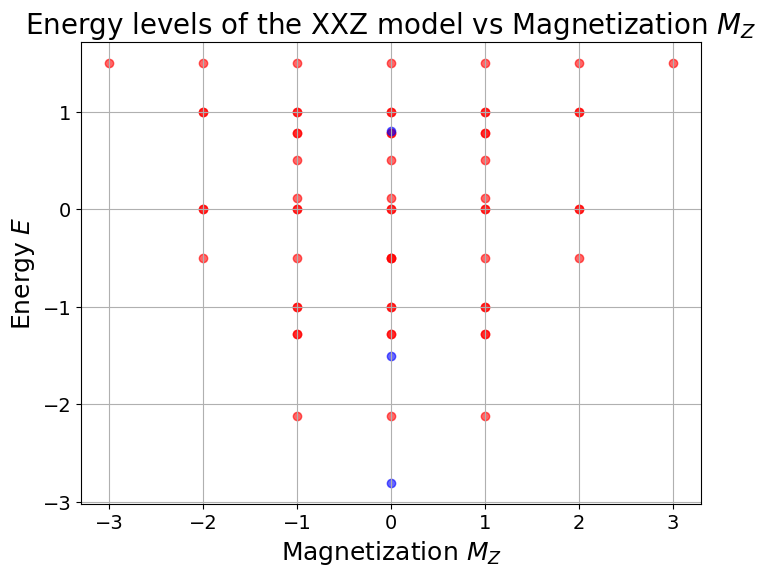

In [43]:
data = []
with open("Data01/" + csv_filename, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        data.append([float(row[0]), float(row[1])])

# Process data
data = np.array(data)
all_magnetizations = data[:, 0]
all_energies = data[:, 1]

# Identify and highlight degenerate energy levels
unique_energies, counts = np.unique(np.round(all_energies, 10), return_counts=True)
degenerate_energies = unique_energies[counts > 1]

# Plot energy levels vs magnetization
plt.figure(figsize=(8, 6))
for Mz, energy in zip(all_magnetizations, all_energies):
    color = 'red' if np.round(energy, 10) in degenerate_energies else 'blue'
    plt.scatter(Mz, energy, c=color, alpha=0.6)
plt.xlabel('Magnetization $M_Z$')
plt.ylabel('Energy $E$')
plt.title('Energy levels of the XXZ model vs Magnetization $M_Z$')
plt.grid()
plt.savefig("Plots01/a_energy_levels.png", bbox_inches = "tight")
plt.show()


# b

In [14]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)


# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)

# Analyze the number of states in different sectors for L=5
L = 5
Delta = 1
Mz_values = [5/2, 3/2, 1/2]

# Count states
state_counts = {Mz: count_states_in_sector(L, Mz) for Mz in Mz_values}
print("Number of states in each Mz sector:", state_counts)

# Identify predictable eigenvalues
# All eigenvalues from Mz = 5/2 should appear in Mz = 3/2 and lower sectors
predictable_eigenvalues = min(state_counts[3/2], state_counts[1/2])
print(f"Number of predictable eigenvalues in Mz = 1/2: {predictable_eigenvalues}")


Number of states in each Mz sector: {2.5: 1, 1.5: 5, 0.5: 10}
Number of predictable eigenvalues in Mz = 1/2: 5


# c

Started L = 4 at: 
Current Time: 09:18:56
Started L = 6 at: 
Current Time: 09:18:56
Started L = 8 at: 
Current Time: 09:18:57
Started L = 10 at: 
Current Time: 09:19:02
Started L = 12 at: 
Current Time: 09:20:06


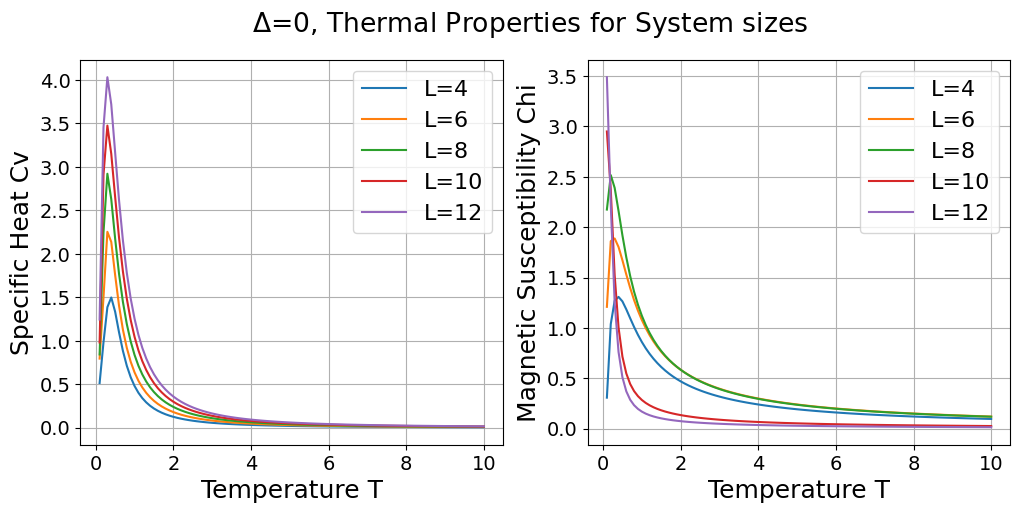

Started L = 4 at: 
Current Time: 10:13:54
Started L = 6 at: 
Current Time: 10:13:54
Started L = 8 at: 
Current Time: 10:13:55
Started L = 10 at: 
Current Time: 10:14:01
Started L = 12 at: 
Current Time: 10:15:21


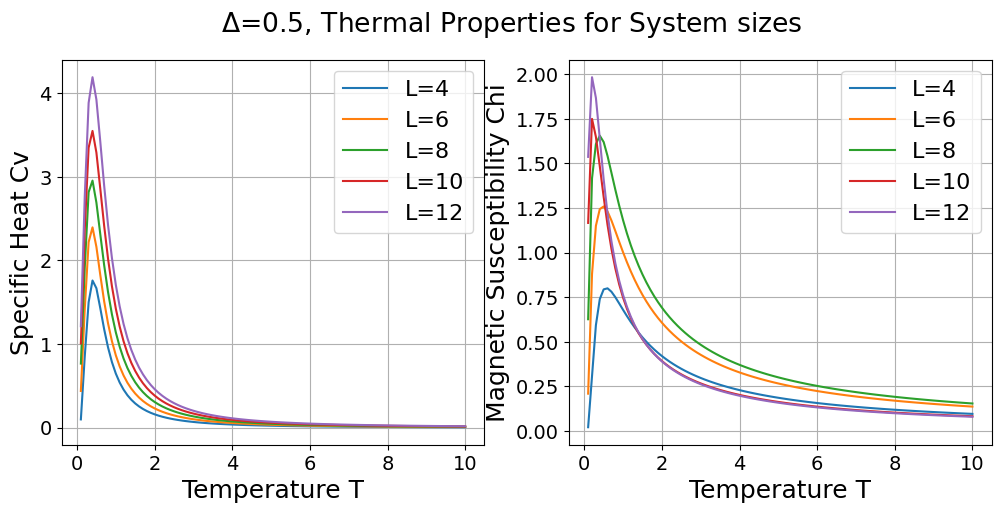

Started L = 4 at: 
Current Time: 11:08:22
Started L = 6 at: 
Current Time: 11:08:23
Started L = 8 at: 
Current Time: 11:08:23
Started L = 10 at: 
Current Time: 11:08:29
Started L = 12 at: 
Current Time: 11:09:43


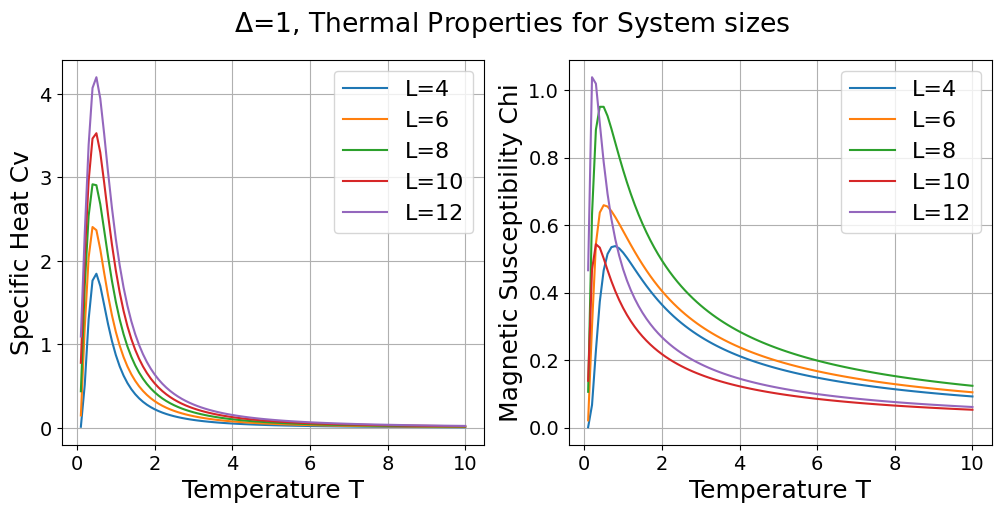

Started L = 4 at: 
Current Time: 12:01:52
Started L = 6 at: 
Current Time: 12:01:52
Started L = 8 at: 
Current Time: 12:01:53
Started L = 10 at: 
Current Time: 12:01:59
Started L = 12 at: 
Current Time: 12:03:21


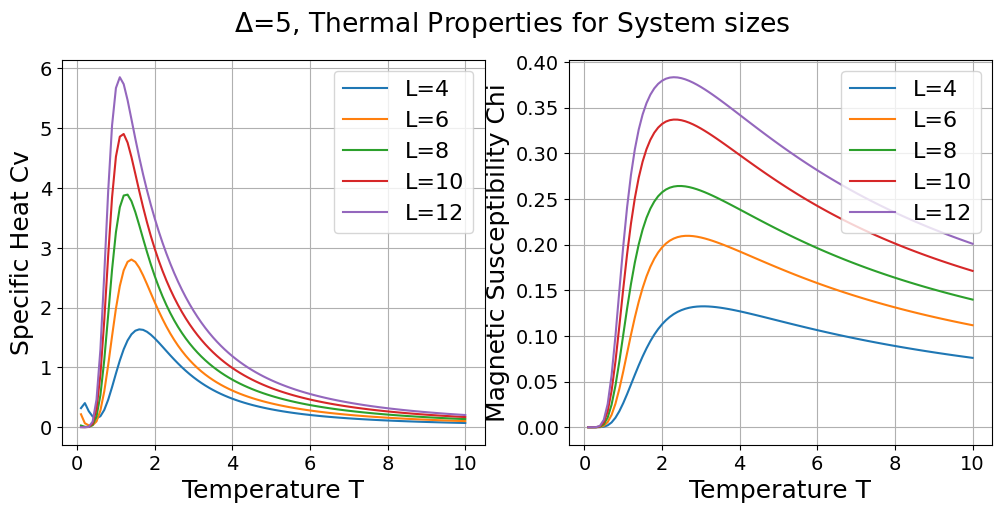

In [20]:
# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Spin operators
Sx = sigma_x / 2
Sy = sigma_y / 2
Sz = sigma_z / 2
Sp = np.array([[0, 1], [0, 0]], dtype=complex)
Sm = np.array([[0, 0], [1, 0]], dtype=complex)

# Parameters
L_values = [4,6,8,10,12]
# L = 10
Delta_values = [0, 0.5, 1, 5]
T_values = np.linspace(0.1, 10, 100)

# Plotting specific heat and susceptibility for different Delta
for Delta in Delta_values:
    plt.figure(figsize=(12,5))
    for L in L_values:
        print(f"Started L = {L} at: ")
        print_current_time()
        Cv_list, chi_list = [], []
        for T in T_values:
            _, Cv, chi = compute_thermal_properties(L, Delta, T)
            Cv_list.append(Cv)
            chi_list.append(chi)

        # Save data to CSV
        filename = f"Data01/c_thermal_data_Delta{Delta}_L{L}.csv"
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Temperature", "Specific Heat (Cv)", "Magnetic Susceptibility (Chi)"])
            for T, Cv, chi in zip(T_values, Cv_list, chi_list):
                writer.writerow([T, Cv, chi])
        
        plt.subplot(1, 2, 1)
        plt.plot(T_values, Cv_list, label=f"L={L}")
        plt.xlabel("Temperature T")
        plt.ylabel("Specific Heat Cv")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(T_values, chi_list, label=f"L={L}")
        plt.xlabel("Temperature T")
        plt.ylabel("Magnetic Susceptibility Chi")
        plt.grid(True)
        plt.legend()

    plt.suptitle(f"$\Delta$={Delta}, Thermal Properties for System sizes")

    plt.savefig(f"Plots01/c_thermal_plots_Delta{Delta}_L{L}.png", bbox_inches= "tight")
    plt.show()

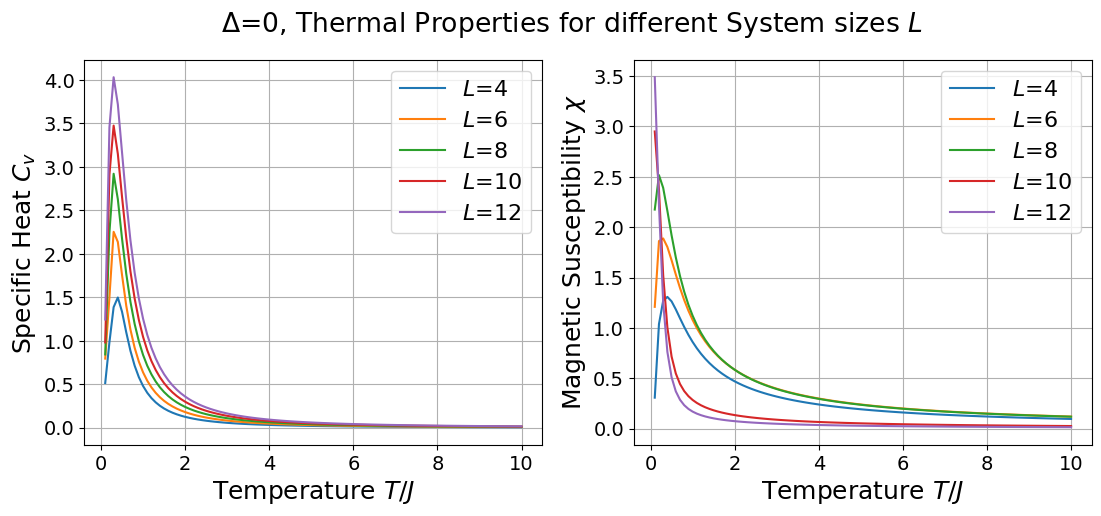

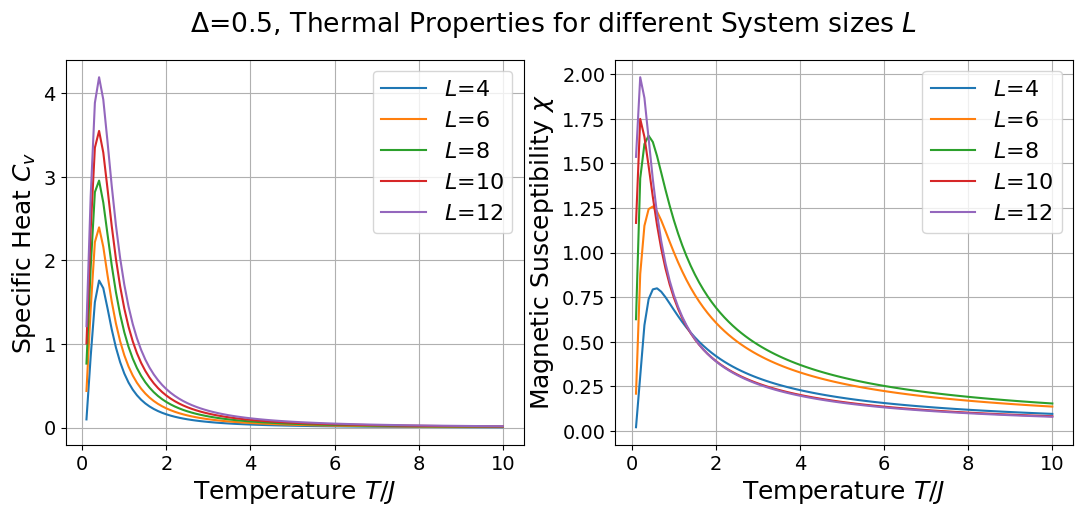

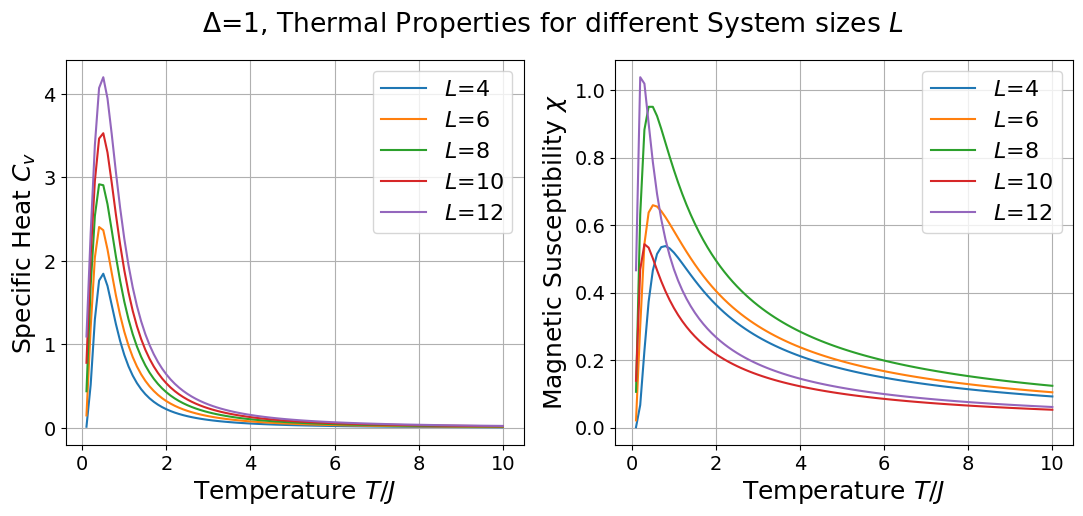

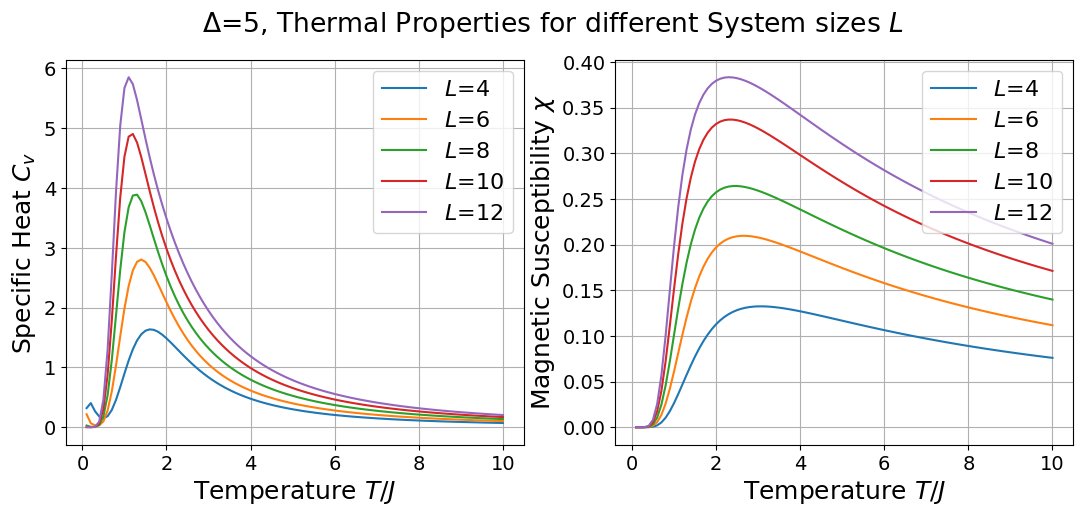

In [38]:
for Delta in Delta_values:
    plt.figure(figsize=(13, 5))

    for L in L_values:
        filename = f"Data01/c_thermal_data_Delta{Delta}_L{L}.csv"
        T_vals, Cv_vals, chi_vals = [], [], []

        # Read data from CSV
        with open(filename, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            for row in reader:
                T_vals.append(float(row[0]))
                Cv_vals.append(float(row[1]))
                chi_vals.append(float(row[2]))

        # Plot data
        plt.subplot(1, 2, 1)
        plt.plot(T_vals, Cv_vals, label=f"$L$={L}")
        plt.xlabel(f"Temperature $T/J$")
        plt.ylabel(f"Specific Heat $C_v$")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(T_vals, chi_vals, label=f"$L$={L}")
        plt.xlabel("Temperature $T / J$")
        plt.ylabel(f"Magnetic Susceptibility $\chi$")
        plt.legend()

    plt.suptitle(f"$\Delta$={Delta}, Thermal Properties for different System sizes $L$")
    plt.grid(True)
    plt.savefig(f"Plots01/c_thermal_plots_Delta{Delta}_L{L}.png", bbox_inches= "tight")
    plt.show()

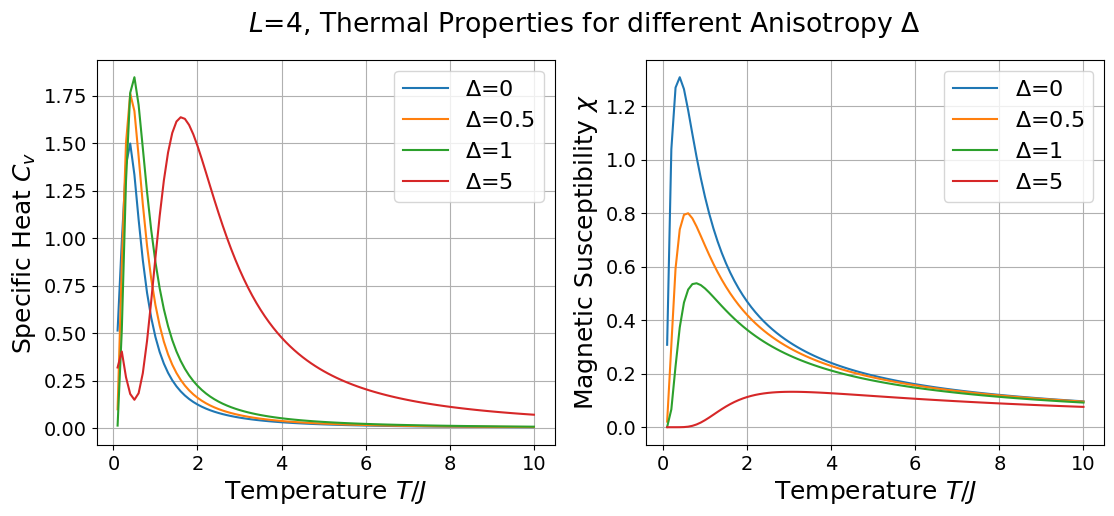

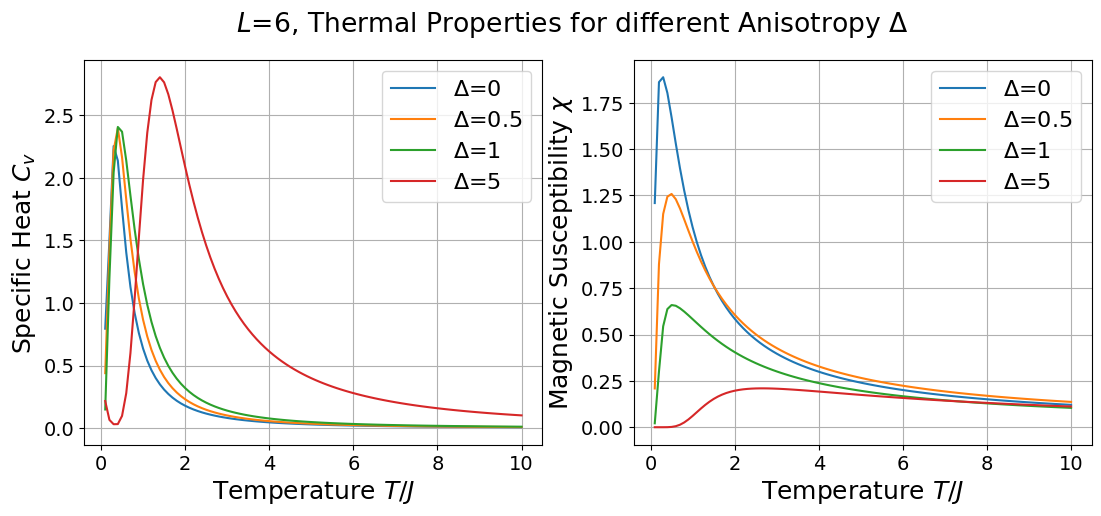

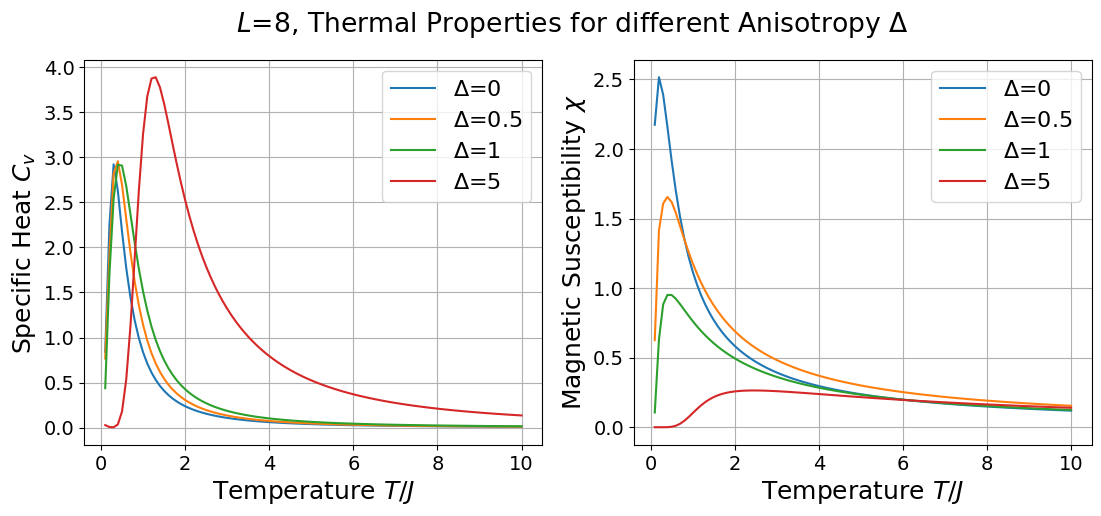

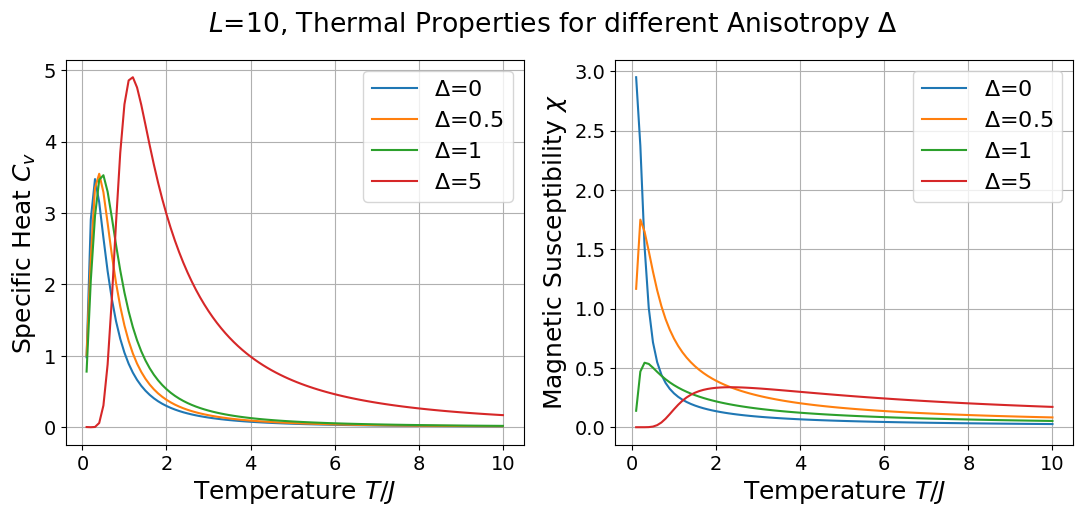

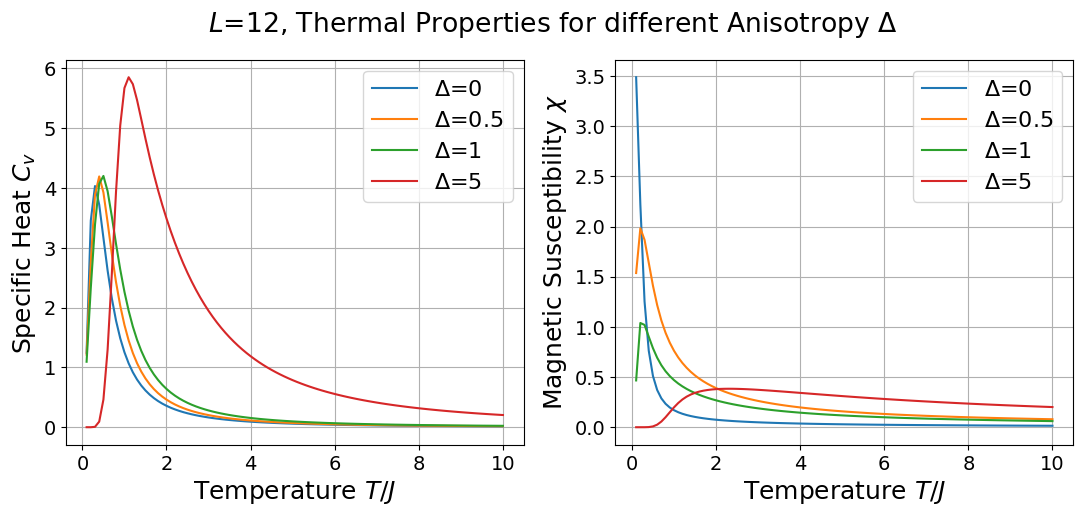

In [45]:
for L in L_values:
    plt.figure(figsize=(13, 5))

    for Delta in Delta_values:
        filename = f"Data01/c_thermal_data_Delta{Delta}_L{L}.csv"
        T_vals, Cv_vals, chi_vals = [], [], []

        # Read data from CSV
        with open(filename, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            for row in reader:
                T_vals.append(float(row[0]))
                Cv_vals.append(float(row[1]))
                chi_vals.append(float(row[2]))

        # Plot data
        plt.subplot(1, 2, 1)
        plt.plot(T_vals, Cv_vals, label=f"$\Delta$={Delta}")
        plt.xlabel(f"Temperature $T/J$")
        plt.ylabel(f"Specific Heat $C_v$")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(T_vals, chi_vals, label=f"$\Delta$={Delta}")
        plt.xlabel("Temperature $T / J$")
        plt.ylabel(f"Magnetic Susceptibility $\chi$")
        plt.legend()

    plt.suptitle(f"$L$={L}, Thermal Properties for different Anisotropy $\Delta$")
    plt.grid(True)
    plt.savefig(f"Plots01/c_alternative_thermal_plots_L{L}_Delta{Delta}.png", bbox_inches= "tight")
    plt.show()